**Pre-processing**

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import Levenshtein
import time
import json
# Input & Output directories
input_dir = './data'
output_dir = './processed_dataset'
os.makedirs(output_dir, exist_ok=True)

# Create subdirectories for segmentation outputs
os.makedirs(os.path.join(output_dir, 'lines'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'words'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'chars'), exist_ok=True)

def deskew(image):
    """Corrects skew using text region coordinates"""
    coords = np.column_stack(np.where(image > 0))
    if len(coords) == 0:
        return image  # No text to deskew
    
    angle = cv2.minAreaRect(coords)[-1]
    angle = -angle if angle < -45 else -(90 + angle)
    
    (h, w) = image.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderValue=0)
    return rotated

def get_horizontal_projection(image):
    return np.sum(image, axis=1) // 255

def get_vertical_projection(image):
    return np.sum(image, axis=0) // 255

def segment_lines(image, min_height=10):
    projection = get_horizontal_projection(image)
    in_line, start_idx, end_idx = False, [], []
    
    for i, val in enumerate(projection):
        if val > 0 and not in_line:
            in_line = True
            start_idx.append(i)
        elif val == 0 and in_line:
            in_line = False
            end_idx.append(i)
    if in_line:
        end_idx.append(len(projection)-1)
    
    lines = []
    for s, e in zip(start_idx, end_idx):
        if e-s >= min_height:
            line_img = image[s:e, :]
            lines.append(line_img)
    return lines

def segment_words(line_image, min_width=10):
    projection = get_vertical_projection(line_image)
    in_word, start_idx, end_idx = False, [], []
    
    for i, val in enumerate(projection):
        if val > 0 and not in_word:
            in_word = True
            start_idx.append(i)
        elif val == 0 and in_word:
            in_word = False
            end_idx.append(i)
    if in_word:
        end_idx.append(len(projection)-1)
    
    words = []
    for s, e in zip(start_idx, end_idx):
        if e-s >= min_width:
            word_img = line_image[:, s:e]
            words.append(word_img)
    return words

def segment_characters(word_image, min_width=5):
    projection = get_vertical_projection(word_image)
    in_char, start_idx, end_idx = False, [], []
    
    for i, val in enumerate(projection):
        if val > 0 and not in_char:
            in_char = True
            start_idx.append(i)
        elif val == 0 and in_char:
            in_char = False
            end_idx.append(i)
    if in_char:
        end_idx.append(len(projection)-1)
    
    chars = []
    for s, e in zip(start_idx, end_idx):
        if e-s >= min_width:
            char_img = word_image[:, s:e]
            chars.append(char_img)
    return chars

# Main processing loop
image_paths = sorted(glob(os.path.join(input_dir, '*.jpg')))
print(f"Found {len(image_paths)} images.")

for img_path in tqdm(image_paths, desc="Processing Images"):
    # Load and preprocess
    pil_img = Image.open(img_path).convert('L')
    img = np.array(pil_img)
    
    # Denoising
    denoised = cv2.medianBlur(img, 5)
    
    # Binarization with adaptive threshold
    binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    # Deskew
    deskewed = deskew(binary)
    
    # Morphological closing
    kernel = np.ones((3,3), np.uint8)
    closed = cv2.morphologyEx(deskewed, cv2.MORPH_CLOSE, kernel)
    
    # Save processed image
    filename = os.path.basename(img_path)
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, closed)
    
    # Segmentation
    image_name = os.path.splitext(filename)[0]
    processed_img = closed
    
    # Line segmentation
    lines = segment_lines(processed_img)
    line_dir = os.path.join(output_dir, 'lines', image_name)
    os.makedirs(line_dir, exist_ok=True)
    
    for line_idx, line in enumerate(lines):
        line_save_path = os.path.join(line_dir, f'line_{line_idx}.jpg')
        cv2.imwrite(line_save_path, line)
        
        # Word segmentation
        words = segment_words(line)
        word_dir = os.path.join(output_dir, 'words', image_name, f'line_{line_idx}')
        os.makedirs(word_dir, exist_ok=True)
        
        for word_idx, word in enumerate(words):
            word_save_path = os.path.join(word_dir, f'word_{word_idx}.jpg')
            cv2.imwrite(word_save_path, word)
            
            # Character segmentation
            chars = segment_characters(word)
            char_dir = os.path.join(output_dir, 'chars', image_name, 
                                   f'line_{line_idx}', f'word_{word_idx}')
            os.makedirs(char_dir, exist_ok=True)
            
            for char_idx, char in enumerate(chars):
                char_save_path = os.path.join(char_dir, f'char_{char_idx}.jpg')
                cv2.imwrite(char_save_path, char)

print(f"\n✅ Processing complete. Outputs saved in: {output_dir}")

Found 129 images.


Processing Images: 100%|██████████| 129/129 [00:06<00:00, 18.76it/s]


✅ Processing complete. Outputs saved in: ./processed_dataset


In [7]:
import shutil

shutil.make_archive('/kaggle/working/processed_dataset', 'zip', output_dir)
print("✅ Zipped processed data.")


✅ Zipped processed data.


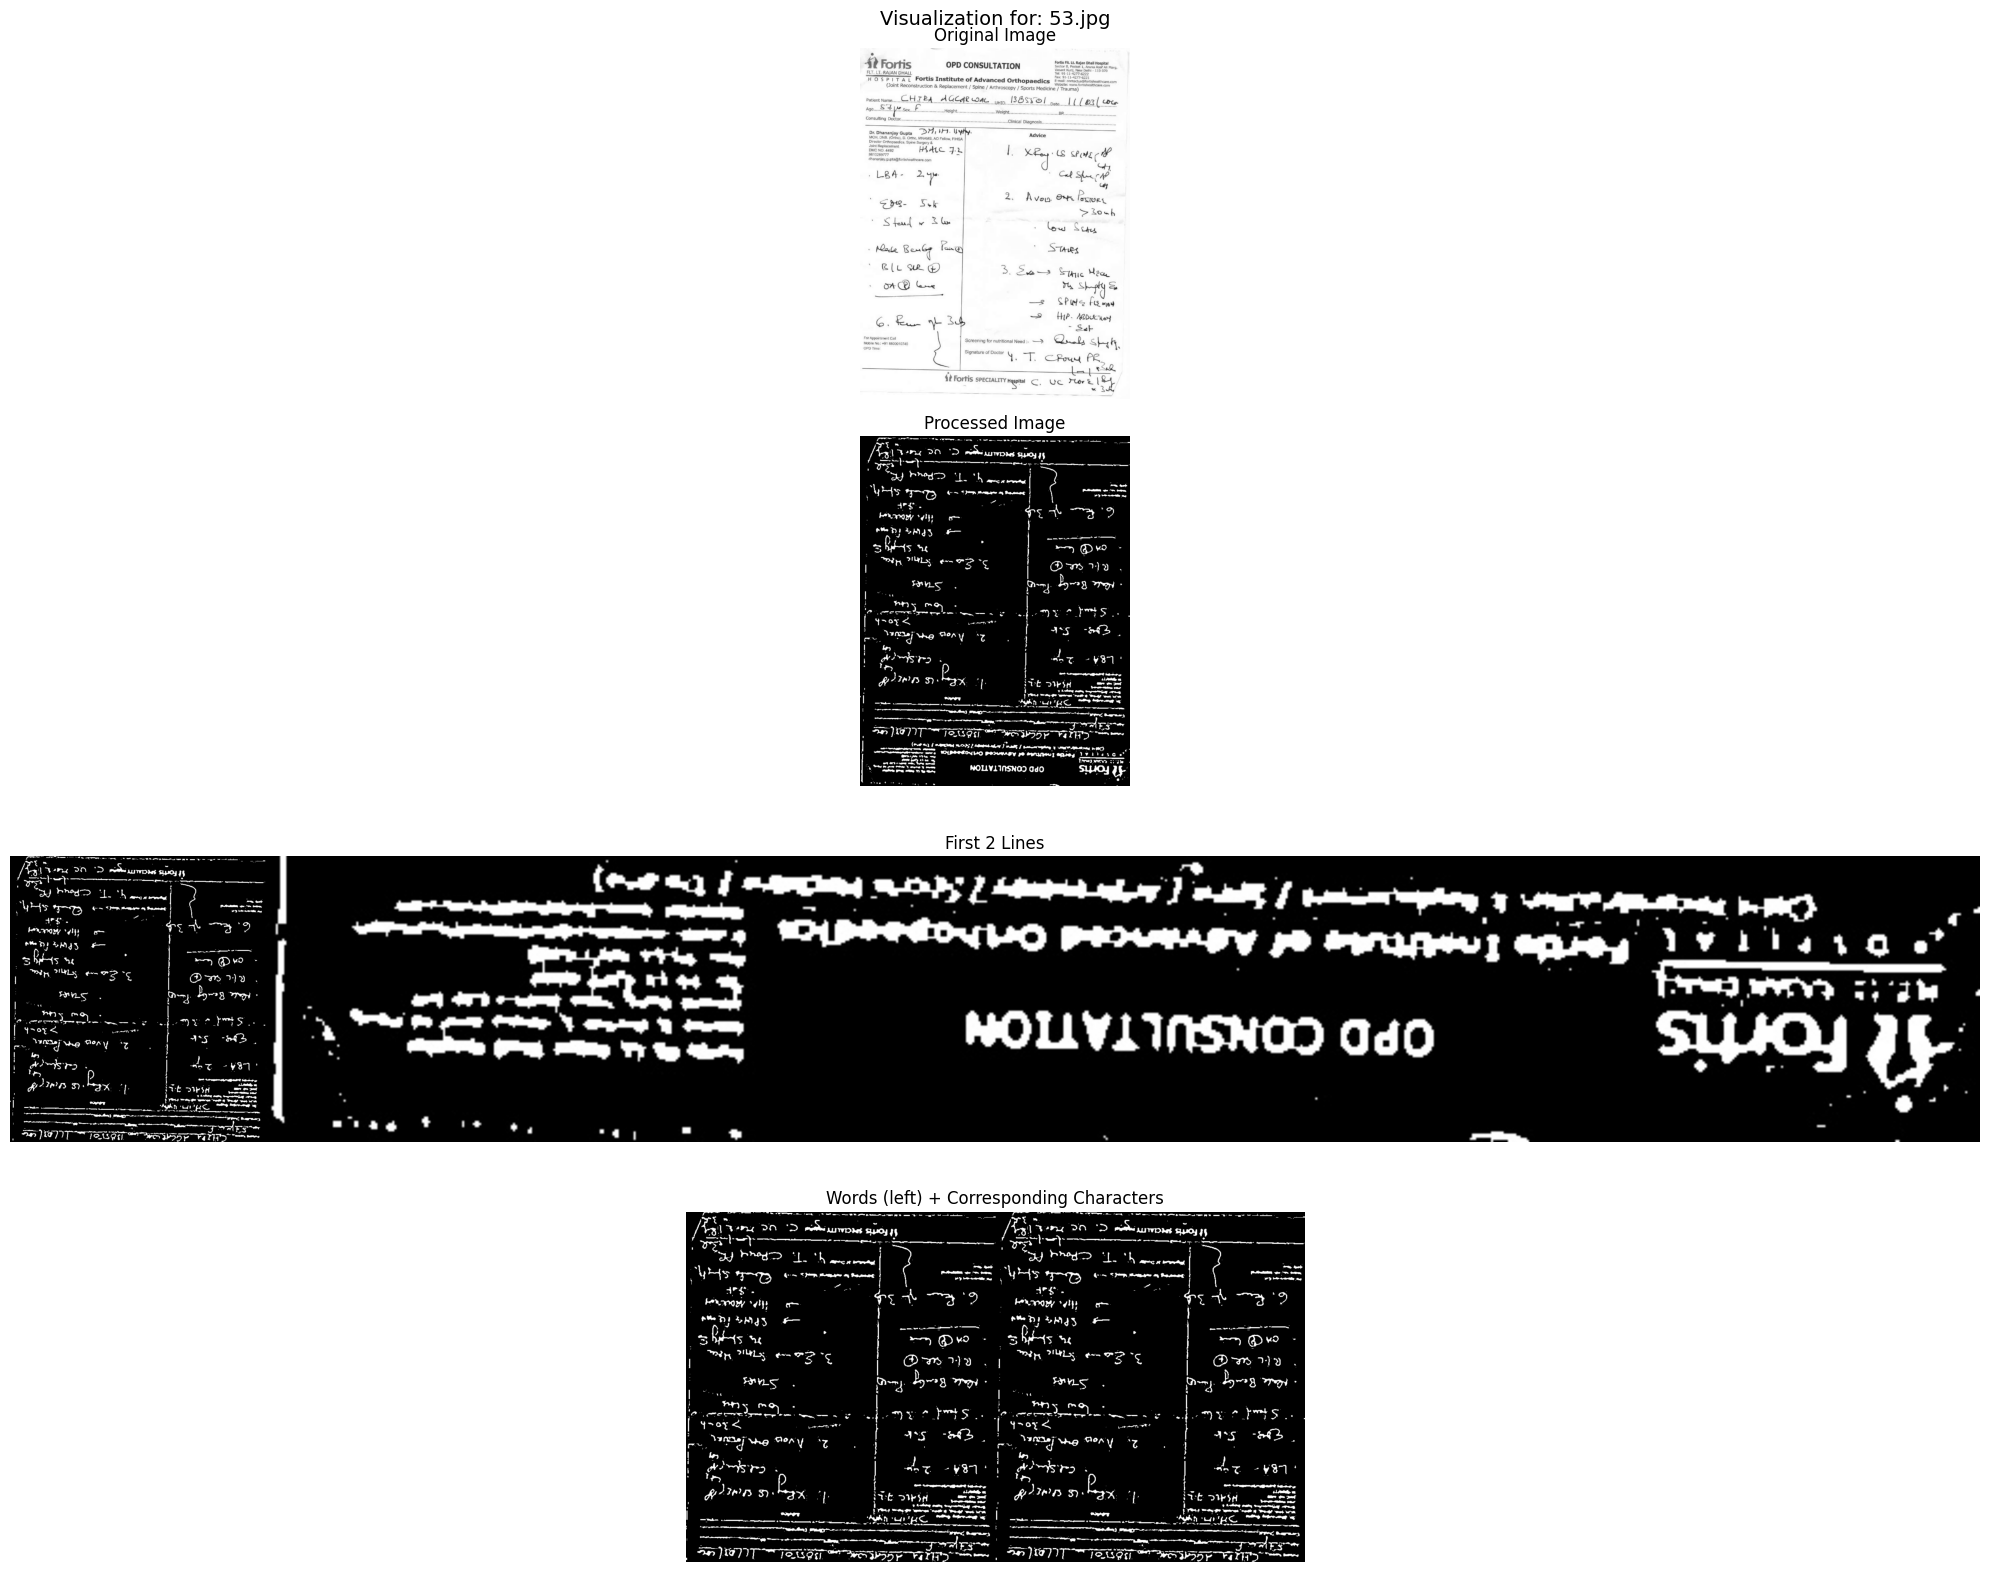

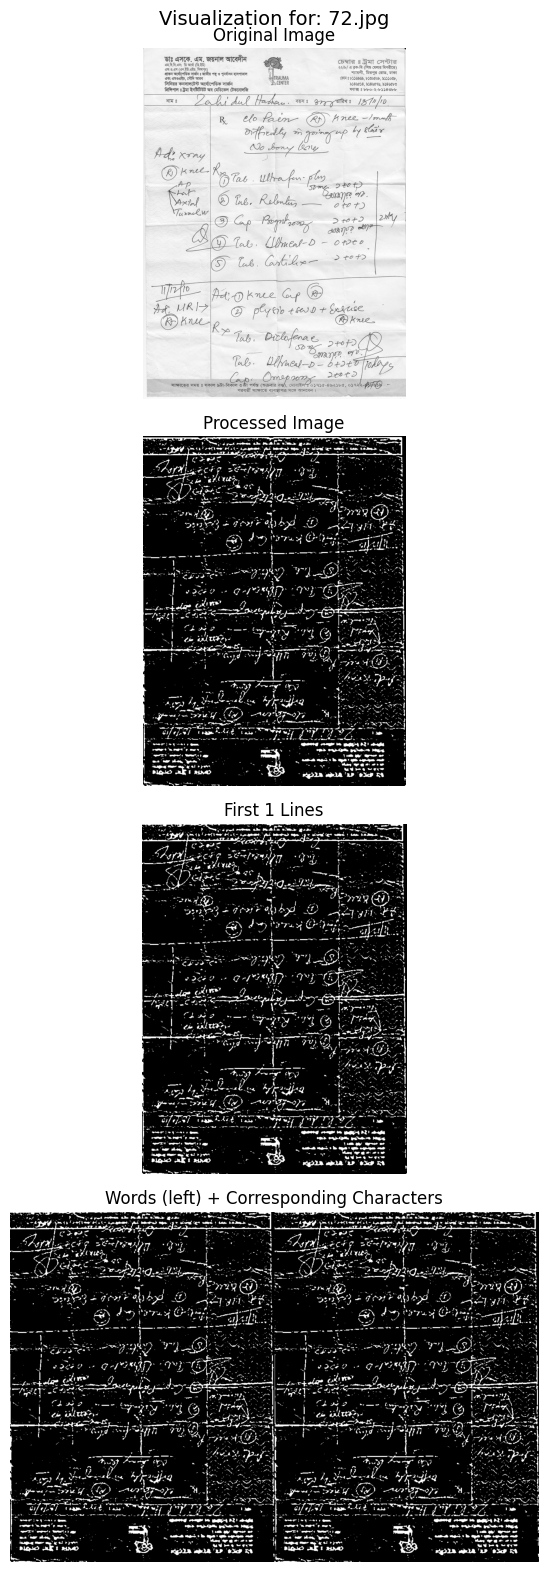

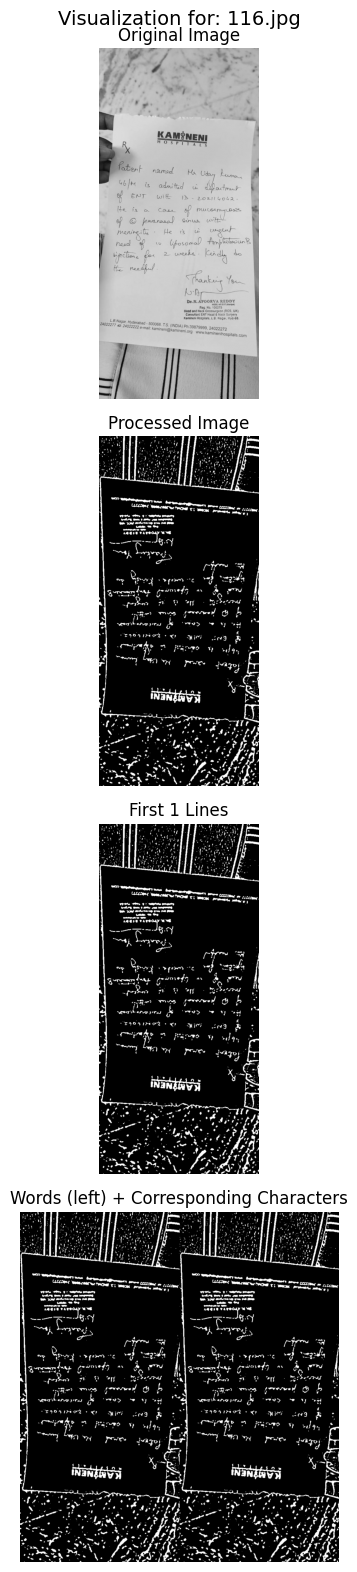

In [9]:
import matplotlib.pyplot as plt
import random

def resize_to_height(image, target_height):
    """Resize image while maintaining aspect ratio"""
    if image is None or image.size == 0:
        return None
    h, w = image.shape
    ratio = target_height / h
    new_width = int(w * ratio)
    return cv2.resize(image, (new_width, target_height), interpolation=cv2.INTER_LINEAR)

def visualize_results(sample_size=3):
    image_paths = glob(os.path.join(input_dir, '*.jpg'))
    sample_paths = random.sample(image_paths, min(sample_size, len(image_paths)))
    
    for img_path in sample_paths:
        # Load images
        original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        processed = cv2.imread(os.path.join(output_dir, os.path.basename(img_path)), cv2.IMREAD_GRAYSCALE)
        
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        line_dir = os.path.join(output_dir, 'lines', base_name)

        plt.figure(figsize=(20, 16))
        plt.suptitle(f'Visualization for: {os.path.basename(img_path)}', fontsize=14)

        # Original vs Processed
        plt.subplot(4, 1, 1)
        plt.imshow(original, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(4, 1, 2)
        plt.imshow(processed, cmap='gray')
        plt.title("Processed Image")
        plt.axis('off')

        # Line segmentation with fixed height
        plt.subplot(4, 1, 3)
        if os.path.exists(line_dir):
            line_images = []
            for f in os.listdir(line_dir)[:3]:
                img = cv2.imread(os.path.join(line_dir, f), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    line_images.append(img)
            
            if line_images:
                # Resize to common height
                heights = [img.shape[0] for img in line_images]
                target_height = max(heights)
                resized_lines = [resize_to_height(img, target_height) for img in line_images]
                line_mosaic = np.concatenate(resized_lines, axis=1)
                plt.imshow(line_mosaic, cmap='gray')
                plt.title(f"First {len(line_images)} Lines")
            else:
                plt.title("No lines detected")
            plt.axis('off')
        else:
            plt.title("Line directory not found")
            plt.axis('off')

        # Word and character segmentation with dynamic resizing
        plt.subplot(4, 1, 4)
        word_dir = os.path.join(output_dir, 'words', base_name)
        if os.path.exists(word_dir):
            try:
                line_folders = os.listdir(word_dir)
                if line_folders:
                    first_line = os.path.join(word_dir, line_folders[0])
                    word_images = []
                    for wf in os.listdir(first_line)[:3]:
                        word_img = cv2.imread(os.path.join(first_line, wf), cv2.IMREAD_GRAYSCALE)
                        if word_img is not None:
                            word_images.append(word_img)
                    
                    if word_images:
                        # Process words and characters
                        rows = []
                        for word_img in word_images:
                            # Get characters
                            char_dir = os.path.join(output_dir, 'chars', base_name, 
                                                  line_folders[0], os.path.splitext(wf)[0])
                            chars = []
                            if os.path.exists(char_dir):
                                for cf in os.listdir(char_dir)[:3]:
                                    char_img = cv2.imread(os.path.join(char_dir, cf), cv2.IMREAD_GRAYSCALE)
                                    if char_img is not None:
                                        chars.append(char_img)
                            
                            # Resize word and characters to common height
                            elements = [word_img] + chars
                            heights = [e.shape[0] for e in elements if e is not None]
                            if heights:
                                target_h = max(heights)
                                resized = [resize_to_height(e, target_h) if e is not None else np.zeros((target_h, 10)) 
                                          for e in elements]
                                row = np.concatenate(resized, axis=1)
                                rows.append(row)
                        
                        if rows:
                            final_mosaic = np.concatenate(rows, axis=0)
                            plt.imshow(final_mosaic, cmap='gray')
                            plt.title("Words (left) + Corresponding Characters")
            except Exception as e:
                plt.title(f"Error: {str(e)}")
            plt.axis('off')
        else:
            plt.title("Word directory not found")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Visualize 3 random samples
visualize_results(3)

In [ ]:

class CharacterCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharacterCNN, self).__init__()
        # Feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Adaptive pooling to handle variable size inputs
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Classification
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # Input shape: [batch, 1, height, width]
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [ ]:
class CRNN(nn.Module):
    def __init__(self, num_classes, input_height=32):
        super(CRNN, self).__init__()
        
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Calculate feature height after CNN
        self.feature_height = input_height // 8
        
        # Bidirectional LSTM
        self.rnn = nn.Sequential(
            nn.LSTM(512 * self.feature_height, 256, bidirectional=True, batch_first=True),
            nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        )
        
        # Classifier
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        conv = self.cnn(x)  # [batch, channels, height, width]
        
        # Reshape for RNN
        conv = conv.permute(0, 3, 1, 2)  # [batch, width, channels, height]
        conv = conv.contiguous().view(batch_size, -1, 512 * self.feature_height)
        
        # RNN sequence processing
        rnn_out, _ = self.rnn[0](conv)
        rnn_out = rnn_out.view(batch_size, -1, 2, 256)
        rnn_out = rnn_out.sum(dim=2)  # Sum bidirectional outputs
        rnn_out, _ = self.rnn[1](rnn_out)
        rnn_out = rnn_out.view(batch_size, -1, 2, 256)
        rnn_out = rnn_out.sum(dim=2)
        
        # Classification
        output = self.classifier(rnn_out)
        
        return output  # Shape: [batch, sequence, num_classes]

In [ ]:

class CRNN(nn.Module):
    def __init__(self, input_channels=1, hidden_size=256, num_classes=62):
        super(CRNN, self).__init__()
        
        # CNN Feature Extractor
        self.cnn_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Layer 4
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),  # Preserve width for sequence
            
            # Layer 5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            # Layer 6
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            
            # Layer 7
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # RNN for sequence modeling (bidirectional LSTM)
        self.rnn1 = nn.GRU(
            input_size=512,  # Input size is 512 (output channels from CNN)
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        
        self.rnn2 = nn.GRU(
            input_size=hidden_size * 2,  # Input from bidirectional GRU (hidden_size * 2)
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        
        # Final classifier
        self.classifier = nn.Linear(hidden_size * 2, num_classes)
    
    def forward(self, x):
        # Input shape: [batch_size, channels, height, width]
        batch_size = x.size(0)
        
        # CNN feature extraction
        conv = self.cnn_layers(x)
        
        # Prepare for RNN (batch, channels, height, width) -> (batch, width, height*channels)
        # We treat width as sequence length and collapse height and channels for features
        conv = conv.permute(0, 3, 1, 2)  # [batch, width, channels, height]
        conv_seq = conv.reshape(batch_size, conv.size(1), -1)  # [batch, width, features]
        
        # Apply RNN layers
        rnn_out, _ = self.rnn1(conv_seq)
        rnn_out, _ = self.rnn2(rnn_out)
        
        # Apply classifier to each time step
        output = self.classifier(rnn_out)
        
        # Output shape: [batch_size, seq_length, num_classes]
        return output

In [ ]:
class TransformerOCR(nn.Module):
    def __init__(self, num_classes, input_height=32, max_seq_length=100):
        super(TransformerOCR, self).__init__()
        
        # CNN feature extractor (similar to CRNN)
        self.cnn = nn.Sequential(
            # CNN layers as in CRNN
            # ...
        )
        
        # Calculate feature dimensions
        self.feature_height = input_height // 8
        self.hidden_dim = 512
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(self.hidden_dim, max_seq_length)
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=self.hidden_dim, 
            nhead=8, 
            dim_feedforward=2048, 
            dropout=0.1
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=6)
        
        # Classifier
        self.classifier = nn.Linear(self.hidden_dim, num_classes)
        
    def forward(self, x):
        # CNN feature extraction
        batch_size = x.size(0)
        conv = self.cnn(x)
        
        # Reshape for transformer
        conv = conv.permute(0, 3, 1, 2)  # [batch, width, channels, height]
        conv = conv.contiguous().view(batch_size, -1, self.hidden_dim)
        
        # Add positional encoding
        conv = self.pos_encoder(conv)
        
        # Transformer sequence processing (requires [seq_len, batch, hidden])
        transformer_input = conv.permute(1, 0, 2)
        transformer_output = self.transformer_encoder(transformer_input)
        transformer_output = transformer_output.permute(1, 0, 2)  # [batch, seq, hidden]
        
        # Classification
        output = self.classifier(transformer_output)
        
        return output

In [ ]:
class HandwrittenOCRDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, char_level=True, transform=None):
        self.data_dir = data_dir
        self.char_level = char_level
        self.transform = transform
        
        # Choose appropriate subdirectory
        if char_level:
            self.image_dir = os.path.join(data_dir, 'chars')
        else:
            self.image_dir = os.path.join(data_dir, 'words')
        
        # Get all image paths
        self.image_paths = []
        self.labels = []
        
        # This is where we'll need to add code to load and parse your labels
        # ...
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return image, label

In [ ]:

class CTCTrainingFramework:
    def __init__(self, model, device, learning_rate=0.001, blank_idx=0):
    
        self.model = model
        self.device = device
        self.learning_rate = learning_rate
        self.blank_idx = blank_idx
        
        # Initialize CTC loss
        self.criterion = nn.CTCLoss(blank=blank_idx, reduction='mean', zero_infinity=True)
        
        # Initialize optimizer with learning rate scheduling
        self.optimizer = optim.AdamW(
            model.parameters(), 
            lr=learning_rate,
            weight_decay=1e-5
        )
        
        # Learnin

In [ ]:
def collate_fn(batch):
   
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    
    images, indices, original_texts = zip(*batch)

    images = torch.stack(images, 0)
    
    label_lengths = [len(index_seq) for index_seq in indices]
    max_length = max(label_lengths)
    
    padded_indices = torch.zeros(len(indices), max_length, dtype=torch.long)
    for i, index_seq in enumerate(indices):
        padded_indices[i, :len(index_seq)] = torch.tensor(index_seq, dtype=torch.long)
    
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)
    
    return images, padded_indices, label_lengths, original_texts

In [12]:
class OCREvaluator:

    @staticmethod
    def evaluate_model(model, test_loader, device, idx_to_char, blank_idx=0):
       
        model.eval()
        all_predictions = []
        all_ground_truths = []
        
        example_pairs = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating"):
             
                images, label_indices, _, original_texts = batch
              
                images = images.to(device)
                
                # Forward pass
                outputs = model(images) 
                
                # Decode predictions
                predicted_texts = OCREvaluator.decode_predictions(outputs, idx_to_char, blank_idx)
                
                all_predictions.extend(predicted_texts)
                all_ground_truths.extend(original_texts)
                
                if len(example_pairs) < 10:
                    for pred, gt in zip(predicted_texts, original_texts):
                        if len(example_pairs) < 10:
                            example_pairs.append((pred, gt))
        
        character_accuracy = OCREvaluator.character_accuracy(all_predictions, all_ground_truths)
        word_accuracy = OCREvaluator.word_accuracy(all_predictions, all_ground_truths)
        cer = OCREvaluator.character_error_rate(all_predictions, all_ground_truths)
        wer = OCREvaluator.word_error_rate(all_predictions, all_ground_truths)

        sequence_accuracy = OCREvaluator.sequence_accuracy(all_predictions, all_ground_truths)
        
        char_confusions = OCREvaluator.character_confusion_analysis(all_predictions, all_ground_truths)
        
        # Results
        return {
            "character_accuracy": character_accuracy,
            "word_accuracy": word_accuracy,
            "sequence_accuracy": sequence_accuracy,
            "character_error_rate": cer,
            "word_error_rate": wer,
            "example_pairs": example_pairs,
            "character_confusions": char_confusions
        }
    
    @staticmethod
    def decode_predictions(outputs, idx_to_char, blank_idx=0):
        _, preds_index = outputs.max(2)
        preds_index = preds_index.cpu().numpy()  # [batch, seq]
        
        results = []
        for pred in preds_index:
            # CTC decoding: merge repeated characters and remove blank
            decoded = []
            prev_char = -1
            for p in pred:
                if p != blank_idx and p != prev_char:  # Skip blanks and repeated characters
                    if p in idx_to_char:
                        decoded.append(idx_to_char[p])
                prev_char = p
            
            # Join characters into a string
            text = ''.join(decoded)
            results.append(text)
        
        return results
    
    @staticmethod
    def character_accuracy(predictions, targets):
        """Calculate character-level accuracy"""
        correct_chars = 0
        total_chars = 0
        
        for pred, target in zip(predictions, targets):
            # Count matching characters
            for p_char, t_char in zip(pred, target):
                if p_char == t_char:
                    correct_chars += 1
            
            # Account for length differences
            total_chars += max(len(pred), len(target))
        
        # Avoid division by zero
        if total_chars == 0:
            return 0.0
            
        return correct_chars / total_chars
    
    @staticmethod
    def word_accuracy(predictions, targets):
        """Calculate word-level accuracy"""
        correct_words = 0
        total_words = 0
        
        for pred, target in zip(predictions, targets):
            # Split into words
            pred_words = pred.split()
            target_words = target.split()
            
            # Count matching words
            for p_word, t_word in zip(pred_words, target_words):
                if p_word == t_word:
                    correct_words += 1
            
            # Account for length differences
            total_words += max(len(pred_words), len(target_words))
        
        # Avoid division by zero
        if total_words == 0:
            return 0.0
            
        return correct_words / total_words
    
    @staticmethod
    def character_error_rate(predictions, targets):
        """Calculate Character Error Rate using Levenshtein distance"""
        total_edit_distance = 0
        total_length = 0
        
        for pred, target in zip(predictions, targets):
            # Calculate Levenshtein distance
            edit_distance = Levenshtein.distance(pred, target)
            total_edit_distance += edit_distance
            total_length += len(target)
        
        # Avoid division by zero
        if total_length == 0:
            return 1.0
            
        cer = total_edit_distance / total_length
        return cer
    
    @staticmethod
    def word_error_rate(predictions, targets):
        """Calculate Word Error Rate using Levenshtein distance"""
        total_edit_distance = 0
        total_words = 0
        
        for pred, target in zip(predictions, targets):
            # Split into words
            pred_words = pred.split()
            target_words = target.split()
            
            # Calculate Levenshtein distance at word level
            edit_distance = Levenshtein.distance(pred_words, target_words)
            total_edit_distance += edit_distance
            total_words += len(target_words)
        
        # Avoid division by zero
        if total_words == 0:
            return 1.0
            
        wer = total_edit_distance / total_words
        return wer
    
    @staticmethod
    def sequence_accuracy(predictions, targets):
        """Calculate sequence-level accuracy (exact matches)"""
        correct = 0
        
        for pred, target in zip(predictions, targets):
            if pred == target:
                correct += 1
        
        return correct / len(predictions)
    
    @staticmethod
    def character_confusion_analysis(predictions, targets, top_k=10):
        """Analyze most common character confusions"""
        confusion_counts = {}
        
        for pred, target in zip(predictions, targets):
            # Dynamic programming approach to find alignments
            m, n = len(target), len(pred)
            if m == 0 or n == 0:
                continue
                
            # Initialize matrix
            dp = [[0] * (n+1) for _ in range(m+1)]
            
            # Fill first row and column
            for i in range(m+1):
                dp[i][0] = i
            for j in range(n+1):
                dp[0][j] = j
            
            # Fill the matrix
            for i in range(1, m+1):
                for j in range(1, n+1):
                    if target[i-1] == pred[j-1]:
                        dp[i][j] = dp[i-1][j-1]
                    else:
                        dp[i][j] = min(
                            dp[i-1][j] + 1,    # Deletion
                            dp[i][j-1] + 1,    # Insertion
                            dp[i-1][j-1] + 1   # Substitution
                        )
            
            # Backtrack to find alignments
            i, j = m, n
            while i > 0 and j > 0:
                if target[i-1] == pred[j-1]:
                    # Characters match
                    i -= 1
                    j -= 1
                else:
                    # Substitution (different characters aligned)
                    if dp[i][j] == dp[i-1][j-1] + 1:
                        confusion_pair = (target[i-1], pred[j-1])
                        confusion_counts[confusion_pair] = confusion_counts.get(confusion_pair, 0) + 1
                        i -= 1
                        j -= 1
                    # Deletion or insertion
                    elif dp[i][j] == dp[i-1][j] + 1:
                        i -= 1
                    else:
                        j -= 1
        
        # Get top K most common confusions
        sorted_confusions = sorted(confusion_counts.items(), key=lambda x: x[1], reverse=True)
        return sorted_confusions[:top_k]

In [13]:
class MedicalPostProcessor:
    def __init__(self, medical_dict_path=None, custom_abbreviations=None, distance_threshold=2):
    
        self.distance_threshold = distance_threshold
        
        # Load medical dictionary
        self.medical_terms = {}
        if medical_dict_path and os.path.exists(medical_dict_path):
            with open(medical_dict_path, 'r') as f:
                medical_terms_list = [line.strip() for line in f.readlines()]
                self.medical_terms = {term.lower(): term for term in medical_terms_list}
        
        # If no dictionary is provided, use a small default set of common medical terms
        if not self.medical_terms:
            common_terms = [
                "patient", "diagnosis", "treatment", "prescription", "medication",
                "dosage", "symptom", "assessment", "examination", "history",
                "blood pressure", "heart rate", "temperature", "respiratory rate",
                "allergies", "diabetes", "hypertension", "asthma", "arthritis",
                "antibiotics", "analgesics", "anti-inflammatory", "follow-up"
            ]
            self.medical_terms = {term.lower(): term for term in common_terms}
        
        # Common medical abbreviations
        self.abbreviations = {
            "pt": "patient",
            "dx": "diagnosis",
            "tx": "treatment",
            "hx": "history",
            "rx": "prescription",
            "sx": "symptoms",
            "fx": "fracture",
            "bp": "blood pressure",
            "hr": "heart rate",
            "rr": "respiratory rate",
            "temp": "temperature",
            "lab": "laboratory",
            "abx": "antibiotics",
            "bid": "twice daily",
            "tid": "three times daily",
            "qid": "four times daily",
            "prn": "as needed",
            "po": "by mouth",
            "iv": "intravenous",
            "im": "intramuscular",
            "sc": "subcutaneous"
        }
        
        # Add custom abbreviations
        if custom_abbreviations:
            self.abbreviations.update(custom_abbreviations)
    
    def process(self, text):
        """
        Apply medical post-processing to recognized text
        
        Args:
            text: Raw recognized text
            
        Returns:
            Corrected text
        """
        # Split text into words
        words = text.split()
        corrected_words = []
        
        for word in words:
            # Skip very short words or punctuation-only words
            if len(word) <= 1 or all(c in '.,;:!?()-' for c in word):
                corrected_words.append(word)
                continue
            
            # Check if word is an abbreviation
            lower_word = word.lower()
            if lower_word in self.abbreviations:
                # Replace with expanded form
                corrected_words.append(self.abbreviations[lower_word])
                continue
            
            # Check if word is already a known medical term (case-insensitive)
            if lower_word in self.medical_terms:
                # Replace with correctly capitalized form
                corrected_words.append(self.medical_terms[lower_word])
                continue
            
            # Try to find closest medical term
            corrected_word = self._find_closest_term(word)
            if corrected_word:
                corrected_words.append(corrected_word)
            else:
                corrected_words.append(word)  # Keep original if no correction found
        
        # Join words back into text
        corrected_text = ' '.join(corrected_words)
        
        # Additional context-based corrections
        corrected_text = self._context_correction(corrected_text)
        
        return corrected_text
    
    def _find_closest_term(self, word):
        """Find closest matching term in medical dictionary"""
        word_lower = word.lower()
        best_match = None
        min_distance = float('inf')
        
        # Check each term in dictionary
        for term_lower, term in self.medical_terms.items():
            # Quick length check to avoid unnecessary computations
            if abs(len(term_lower) - len(word_lower)) > self.distance_threshold:
                continue
            
            # Calculate edit distance
            distance = Levenshtein.distance(word_lower, term_lower)
            
            # Update best match if closer
            if distance < min_distance and distance <= self.distance_threshold:
                min_distance = distance
                best_match = term
        
        return best_match
    
    def _context_correction(self, text):
        """Apply context-specific corrections"""
        # Correct common patterns in medical text
        
        # Fix dosage formats (e.g., "5mg" -> "5 mg")
        text = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', text)
        
        # Fix date formats
        text = re.sub(r'(\d{1,2})\/(\d{1,2})\/(\d{2,4})', r'\1/\2/\3', text)
        
        # Fix time formats
        text = re.sub(r'(\d{1,2}):(\d{2})', r'\1:\2', text)
        
        # Add more specific medical context corrections as needed
        
        return text
    
    def add_custom_term(self, term):
        """Add a new term to the medical dictionary"""
        self.medical_terms[term.lower()] = term
    
    def add_custom_abbreviation(self, abbr, expansion):
        """Add a new abbreviation and its expansion"""
        self.abbreviations[abbr.lower()] = expansion
    
    def load_custom_dictionary(self, filepath):
        """Load additional terms from a file"""
        if os.path.exists(filepath):
            with open(filepath, 'r') as f:
                terms = [line.strip() for line in f.readlines()]
                for term in terms:
                    self.add_custom_term(term)
            return True
        return False

In [ ]:
class ExperimentTracker:
  
    
    def __init__(self, experiment_dir="experiments"):
    
        self.experiment_dir = experiment_dir
        os.makedirs(experiment_dir, exist_ok=True)
        
        self.experiments_file = os.path.join(experiment_dir, "experiments.json")
        self.experiments = {}
        
        if os.path.exists(self.experiments_file):
            try:
                with open(self.experiments_file, 'r') as f:
                    self.experiments = json.load(f)
            except json.JSONDecodeError:
                print(f"Warning: Could not load experiments file. Starting fresh.")
    
    def start_experiment(self, name, description="", model_type="", hyperparams=None):
     
        # Generate unique ID
        experiment_id = f"{name}_{int(time.time())}"
        
        # Create experiment directory
        experiment_path = os.path.join(self.experiment_dir, experiment_id)
        os.makedirs(experiment_path, exist_ok=True)
        
        # Initialize experiment record
        self.experiments[experiment_id] = {
            "name": name,
            "description": description,
            "model_type": model_type,
            "hyperparams": hyperparams or {},
            "start_time": time.strftime("%Y-%m-%d %H:%M:%S"),
            "status": "running",
            "metrics": {},
            "checkpoints": [],
            "log_file": os.path.join(experiment_path, "log.txt")
        }
        
        # Save experiment record
        self._save_experiments()
        
        # Create log file
        with open(self.experiments[experiment_id]["log_file"], 'w') as f:
            f.write(f"Experiment: {name}\n")
            f.write(f"Description: {description}\n")
            f.write(f"Model type: {model_type}\n")
            f.write(f"Start time: {self.experiments[experiment_id]['start_time']}\n\n")
            
            if hyperparams:
                f.write("Hyperparameters:\n")
                for key, value in hyperparams.items():
                    f.write(f"  {key}: {value}\n")
                f.write("\n")
        
        return experiment_id
    
    def log_metrics(self, experiment_id, epoch, metrics):
        """
        Log metrics for an epoch
        
        Args:
            experiment_id: ID of experiment
            epoch: Current epoch number
            metrics: Dictionary of metric values
        """
        if experiment_id not in self.experiments:
            print(f"Warning: Experiment {experiment_id} not found.")
            return
        
        # Initialize metrics dict if not exists
        if "epochs" not in self.experiments[experiment_id]["metrics"]:
            self.experiments[experiment_id]["metrics"]["epochs"] = {}
        
        # Log metrics for this epoch
        self.experiments[experiment_id]["metrics"]["epochs"][str(epoch)] = metrics
        
        # Update last metrics
        self.experiments[experiment_id]["metrics"]["latest"] = metrics
        
        # Update best metrics
        if "best" not in self.experiments[experiment_id]["metrics"]:
            self.experiments[experiment_id]["metrics"]["best"] = metrics
        else:
            # Update best metrics based on validation loss
            if "val_loss" in metrics and "val_loss" in self.experiments[experiment_id]["metrics"]["best"]:
                if metrics["val_loss"] < self.experiments[experiment_id]["metrics"]["best"]["val_loss"]:
                    self.experiments[experiment_id]["metrics"]["best"] = metrics
        
        # Save to log file
        with open(self.experiments[experiment_id]["log_file"], 'a') as f:
            f.write(f"Epoch {epoch}:\n")
            for key, value in metrics.items():
                f.write(f"  {key}: {value}\n")
            f.write("\n")
        
        # Save experiment record
        self._save_experiments()
    
    def log_checkpoint(self, experiment_id, checkpoint_path, metrics=None):
        """
        Log model checkpoint
        
        Args:
            experiment_id: ID of experiment
            checkpoint_path: Path to saved model checkpoint
            metrics: Optional metrics associated with this checkpoint
        """
        if experiment_id not in self.experiments:
            print(f"Warning: Experiment {experiment_id} not found.")
            return
        
        # Copy checkpoint to experiment directory
        checkpoint_name = os.path.basename(checkpoint_path)
        target_path = os.path.join(self.experiment_dir, experiment_id, checkpoint_name)
        
        # Don't copy if already in experiment directory
        if os.path.abspath(checkpoint_path) != os.path.abspath(target_path):
            shutil.copy(checkpoint_path, target_path)
        
        # Log checkpoint
        checkpoint_info = {
            "path": target_path,
            "time": time.strftime("%Y-%m-%d %H:%M:%S")
        }
        
        if metrics:
            checkpoint_info["metrics"] = metrics
        
        self.experiments[experiment_id]["checkpoints"].append(checkpoint_info)
        
        # Update log file
        with open(self.experiments[experiment_id]["log_file"], 'a') as f:
            f.write(f"Checkpoint saved: {target_path}\n")
            if metrics:
                for key, value in metrics.items():
                    f.write(f"  {key}: {value}\n")
            f.write("\n")
        
        # Save experiment record
        self._save_experiments()
    
    def complete_experiment(self, experiment_id, final_metrics=None):
        """
        Mark an experiment as complete
        
        Args:
            experiment_id: ID of experiment
            final_metrics: Final evaluation metrics
        """
        if experiment_id not in self.experiments:
            print(f"Warning: Experiment {experiment_id} not found.")
            return
        
        # Update experiment status
        self.experiments[experiment_id]["status"] = "completed"
        self.experiments[experiment_id]["end_time"] = time.strftime("%Y-%m-%d %H:%M:%S")
        
        if final_metrics:
            self.experiments[experiment_id]["metrics"]["final"] = final_metrics
        
        # Update log file
        with open(self.experiments[experiment_id]["log_file"], 'a') as f:
            f.write(f"Experiment completed at: {self.experiments[experiment_id]['end_time']}\n")
            if final_metrics:
                f.write("Final metrics:\n")
                for key, value in final_metrics.items():
                    f.write(f"  {key}: {value}\n")
            f.write("\n")
        
        # Save experiment record
        self._save_experiments()
    
    def get_experiment(self, experiment_id):
        """Get experiment details by ID"""
        return self.experiments.get(experiment_id)
    
    def get_all_experiments(self):
        """Get all experiments"""
        return self.experiments
    
    def compare_experiments(self, experiment_ids, metric_name="val_loss"):
  
        comparison = {}
        
        for exp_id in experiment_ids:
            if exp_id not in self.experiments:
                print(f"Warning: Experiment {exp_id} not found.")
                continue
            
            experiment = self.experiments[exp_id]
            
            # Extract metric values across epochs
            epochs = []
            values = []
            
            if "epochs" in experiment["metrics"]:
                for epoch, metrics in experiment["metrics"]["epochs"].items():
                    if metric_name in metrics:
                        epochs.append(int(epoch))
                        values.append(metrics[metric_name])
            
            # Get best value
            best_value = None
            if "best" in experiment["metrics"] and metric_name in experiment["metrics"]["best"]:
                best_value = experiment["metrics"]["best"][metric_name]
            
            comparison[exp_id] = {
                "name": experiment["name"],
                "model_type": experiment["model_type"],
                "epochs": epochs,
                "values": values,
                "best": best_value
            }
        
        return comparison
    
    def plot_comparison(self, experiment_ids, metric_name="val_loss", title=None):
 
        import matplotlib.pyplot as plt
        
        comparison = self.compare_experiments(experiment_ids, metric_name)
        
        plt.figure(figsize=(10, 6))
        
        for exp_id, data in comparison.items():
            if data["epochs"] and data["values"]:
                plt.plot(data["epochs"], data["values"], marker='o', label=f"{data['name']} ({data['model_type']})")
        
        plt.xlabel("Epoch")
        plt.ylabel(metric_name)
        plt.title(title or f"Comparison of {metric_name} across experiments")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        return plt.gcf()
    
    def _save_experiments(self):
        """Save experiments to JSON file"""
        with open(self.experiments_file, 'w') as f:
            json.dump(self.experiments, f, indent=2)

In [ ]:
def train_medical_ocr(model, train_dataset, val_dataset, test_dataset, 
                       experiment_name, batch_size=16, num_epochs=30, 
                       learning_rate=0.001, medical_dict_path=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create data loaders with custom collate function
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=4, collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, collate_fn=collate_fn
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, collate_fn=collate_fn
    )
    
    # Initialize training framework
    framework = CTCTrainingFramework(
        model=model,
        device=device,
        learning_rate=learning_rate,
        blank_idx=0  # Assuming 0 is blank token index
    )
    
    # Initialize experiment tracker
    tracker = ExperimentTracker()
    
    # Start experiment
    hyperparams = {
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "model_type": model.__class__.__name__,
        "model_params": {p: getattr(model, p) for p in dir(model) 
                         if not p.startswith('_') and not callable(getattr(model, p))}
    }
    
    experiment_id = tracker.start_experiment(
        name=experiment_name,
        description="Medical handwritten OCR training",
        model_type=model.__class__.__name__,
        hyperparams=hyperparams
    )
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train one epoch
        train_loss = framework.train_epoch(train_loader)
        
        # Validate
        val_loss, char_acc, word_acc = framework.validate(
            val_loader, train_dataset.idx_to_char
        )
        
        # Log metrics
        metrics = {
            "train_loss": train_loss,
            "val_loss": val_loss,
            "char_accuracy": char_acc,
            "word_accuracy": word_acc,
            "learning_rate": framework.optimizer.param_groups[0]['lr']
        }
        
        tracker.log_metrics(experiment_id, epoch+1, metrics)
        
        # Save checkpoint if best so far
        if val_loss == framework.best_val_loss:
            checkpoint_path = os.path.join("checkpoints", f"{experiment_name}_best.pth")
            os.makedirs("checkpoints", exist_ok=True)
            framework.save_model(checkpoint_path)
            tracker.log_checkpoint(experiment_id, checkpoint_path, metrics)
    
    # Final evaluation
    evaluator = OCREvaluator()
    eval_results = evaluator.evaluate_model(
        model, test_loader, device, train_dataset.idx_to_char
    )
    
    # Apply medical post-processing
    post_processor = MedicalPostProcessor(medical_dict_path=medical_dict_path)
    
    # Test with post-processing
    corrected_results = []
    original_results = eval_results["example_pairs"]  # Get some example pairs
    
    for pred, gt in original_results:
        corrected = post_processor.process(pred)
        corrected_results.append((pred, corrected, gt))
    
    # Log final results
    tracker.complete_experiment(experiment_id, eval_results)
    
    print("\nTraining completed!")
    print(f"Best validation loss: {framework.best_val_loss:.4f}")
    print(f"Best character accuracy: {1.0 - framework.best_cer:.4f}")
    print(f"Best word accuracy: {1.0 - framework.best_wer:.4f}")
    print("\nPost-processing examples:")
    
    for original, corrected, ground_truth in corrected_results[:5]:
        print(f"Original: {original}")
        print(f"Corrected: {corrected}")
        print(f"Ground truth: {ground_truth}")
        print("-" * 50)
    
    return model, experiment_id